### Описание проекта

Построение моделей на основе Марковской цепи.

**Задание**

- скачать текст произведения «Война и мир»: ссылка на [GitHub](https://github.com/netology-code/ds3-spring-2018/tree/master/7.%20Time_series/7.4/war_and_peace) и [Google Drive](https://drive.google.com/drive/u/0/folders/1aM7cNI6Qs7AyeYpQ8lNg7vLsHzIl0JbU);
- очистить его, оставив только русские буквы и символы пробела;
- построить матрицу переходных вероятностей;
- посчитать вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р»;
- используя матрицу переходных вероятностей, сгенерировать слово, начинающееся с буквы «Б» длиной восемь символов;
- для временного ряда произвести оценку через Hidden Markov Models;
- построить через среднее каждой компоненты наивный прогноз ряда.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import re
import wget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from hmmlearn.hmm import GaussianHMM
from scipy.stats import boxcox

np.random.seed(21)

In [2]:
RUSSIAN = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(RUSSIAN)}

### Скачивание и подготовка данных

In [3]:
urls = ['https://drive.google.com/uc?id=1kOVP2UeHtlSGiQ2VT3Wi8t-15x7bCdcR',
       'https://drive.google.com/uc?id=1MQC_nOybYGTGNFYYqpTbAk0OUwSv4i4z',
       'https://drive.google.com/uc?id=1fOHWOxRDMc3_AIU_6YjwoW417tG6Oo_v',
       'https://drive.google.com/uc?id=1CBdGwudgruJTT9h6vo9a-Pei0oXn_1YU']
if not os.path.exists('./data'):
    os.makedirs('./data')
for url in urls:
    wget.download(url, './data/')

100% [..........................................................................] 1273582 / 1273582

100% [..........................................................................] 1356802 / 1356802

 88% [.................................................................         ] 1302528 / 1467361

100% [..........................................................................] 1257579 / 1257579

In [4]:
dir_list = os.listdir('./data/')

In [5]:
text = ''
for file in dir_list:
    with open(f'./data/{file}', 'r') as f:
        volume = f.read().lower()
    volume = re.sub('[^а-яё\s]', '', volume)
    volume = re.sub('[\n]', ' ', volume)
    volume = re.sub('[\s]+', ' ', volume)
    text += volume

### Матрица переходных вероятностей

In [6]:
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1
    
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

Построим матрицу корреляции.

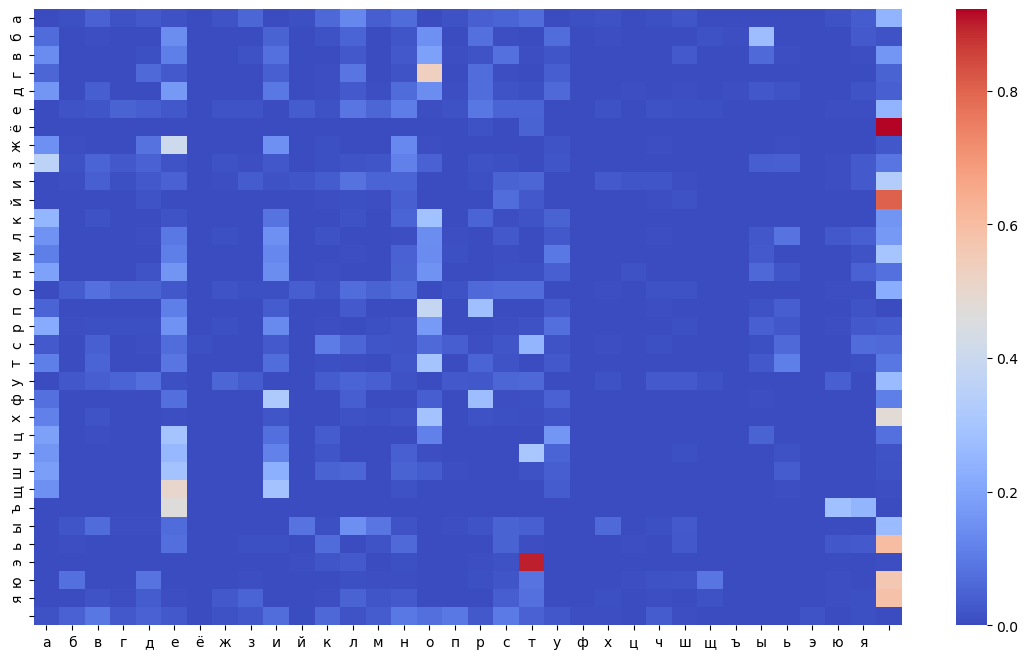

In [7]:
df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))
plt.figure(figsize=(14,8))
sns.heatmap(df, cmap='coolwarm')
plt.show()

### Посчитать вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р»

In [8]:
start = POS['п']
end = POS['р']
prior = 1. / len(RUSSIAN)
final_proba = 0
for snd_char in RUSSIAN:
    for trd_char in RUSSIAN:
        if snd_char != ' ' and trd_char != ' ':
            proba = (prior * probabilities[start, POS[snd_char]]
                    * probabilities[POS[snd_char], POS[trd_char]]
                    * probabilities[POS[trd_char], end] * probabilities[end, POS[' ']])
            final_proba += proba
print(f'Вероятность встретить строку из 4-х символов вида "п__р" = {final_proba}')

Вероятность встретить строку из 4-х символов вида "п__р" = 2.7882795041342983e-05


### Используя матрицу переходных вероятностей, сгенерировать слово, начинающееся с буквы «Б» длиной восемь символов.

In [9]:
s = []
while True:
    start = 'б'
    if start != " ":
        break

s.append(start)
length = 7
for ind in range(length):
    index = POS[s[ind]]
    while True:
        next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
        if next_char != ' ':
            break
            
    s.append(next_char)

print (f'Сгенерированное слово: {"".join(s)}')

Сгенерированное слово: бальейне


### Для временного ряда произвести оценку через Hidden Markov Models

**Подготовка данных**

Из прошлого проекта [Introducing_in_time_series](../1_Introducing_in_time_series/introducing_in_time_series.ipynb) возьмём не стационарный временной ряд "Monthly sales of company" с трендом и сезонностью.

In [10]:
sales_of_company = pd.read_csv('../Data/monthly-sales-of-company-x-jan-6.csv')['Count']

Повторим действия по приведению временного ряда к стационарному виду из [Introducing_in_time_series](../1_Introducing_in_time_series/introducing_in_time_series.ipynb):
- преобразование Бокса-Кокса
- дифференцирование
- дифференцирование с лагом 12
- дифференцирование

In [11]:
sales_of_company = boxcox(sales_of_company, 0)
sales_of_company = sales_of_company[1:] - sales_of_company[:-1]
sales_of_company = sales_of_company[12:] - sales_of_company[:-12]
sales_of_company = sales_of_company[1:] - sales_of_company[:-1]

In [12]:
values = sales_of_company.reshape(-1,1)

In [14]:
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -36.29589854295975
2 -19.919770958306763
3 -10.736309403772802
4 -7.284986550411668
5 1.8043062273112869
6 5.085119605354106


Fitting a model with 79 free scalar parameters with only 63 data points will result in a degenerate solution.
Fitting a model with 98 free scalar parameters with only 63 data points will result in a degenerate solution.


7 7.184359899838656
8 13.84658288699385


Fitting a model with 119 free scalar parameters with only 63 data points will result in a degenerate solution.


9 0.8641177406816678


Fitting a model with 142 free scalar parameters with only 63 data points will result in a degenerate solution.


10 20.03041844643591


Fitting a model with 167 free scalar parameters with only 63 data points will result in a degenerate solution.
Fitting a model with 194 free scalar parameters with only 63 data points will result in a degenerate solution.


11 26.23133761757586
12 14.400280054986915
13 28.692453372355228


**Обучение модели**

Fitting a model with 167 free scalar parameters with only 63 data points will result in a degenerate solution.


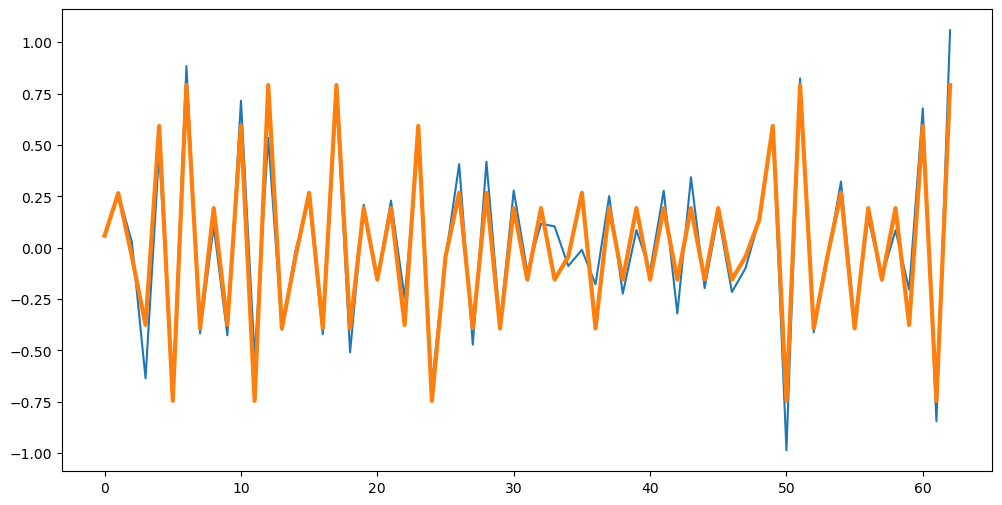

In [15]:
model = GaussianHMM(n_components=12,
                    covariance_type="diag",
                    n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for ind in range(model.n_components):
    means[labels == ind] = model.means_[ind]

plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

### Построение через среднее каждой компоненты наивный прогноз ряда.

In [16]:
pred = 15 #число предсказываемых значений
cur_value = labels[-1]
predictions = []
for _ in range(n):
    cur_value = np.random.choice(12, p=model.transmat_[cur_value])
    predictions.append(model.means_[cur_value])
new_series = np.concatenate((values, np.array(predictions)))

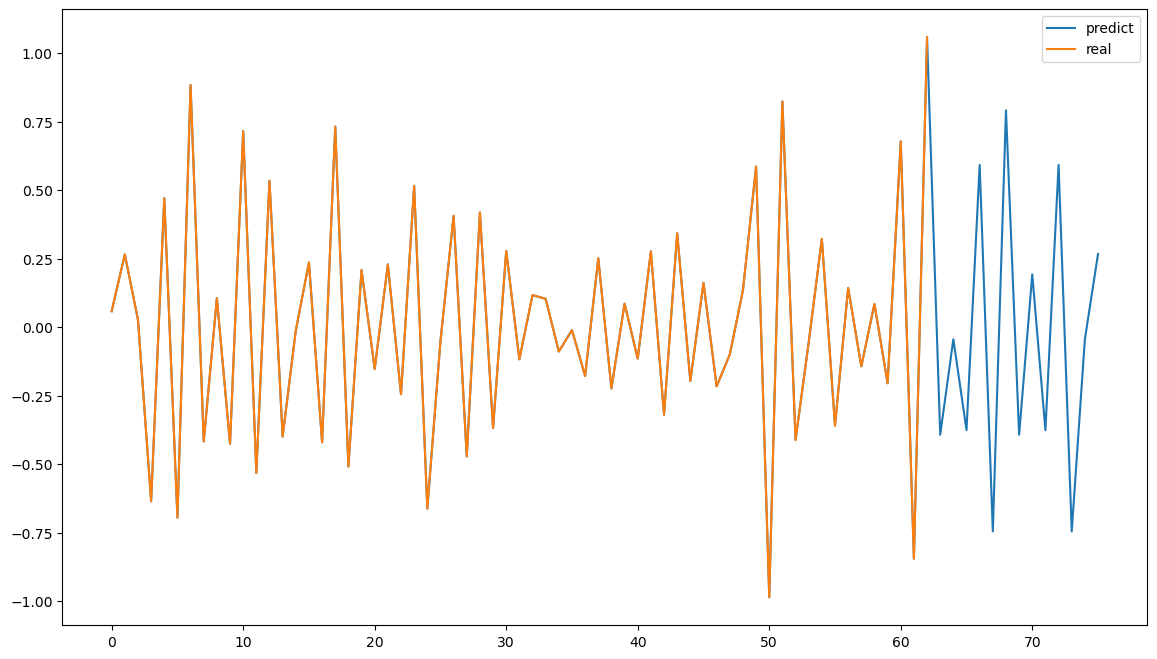

In [17]:
plt.figure(figsize=(14, 8))
plt.plot(new_series, label='predict')
plt.plot(values, label='real')
plt.legend()
plt.show()